## Plot puv fluxes (baroclinic and barotropic energy)
adapted from diag_fluxes_lf.py

Plot snapshots of, e.g. low-pass filtered fields or avg.

Not for animation, so I load every fields

In [52]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, MFDataset
from itertools import product
import numpy as np
import gsw
from scipy.ndimage import gaussian_filter

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [3]:
simul = 'luckyto-beg'
what = "ekint"
dostrflu = False # stream plot of baroclinic flux
dosqflu = True # quiver (by-passed by dostrflu if the latter is True)
it = 240 #182 #436 #182 #    

path_base = KRYPTON + 'DIAG/NRJ_fluxes/'
fil_iflux = path_base+simul+'_bclnrj.?.nc'
fil_sflux = path_base+simul+'_bt_fluxes.?.nc'
fil_grd = KRYPTON + 'lucky_corgrd.nc'
st = 2  #ncr.subsamp_step

units = {"ekint":r"kJ/m$^2$", "flux":r"kw/m", "cterm":r"W/m$^2$",
        "divf":r"W/m$^2$", "dissip":r"W/m$^2$"}
vnam = {key:key for key in ["ekint", "flux", "cterm", "divf", "dissip"]}
vnam["cterm"] = r"$C_t$"
vnam["ekint"] = r"$E_k$"

#plotting parameters
dirpic = './pictures/bclin_fluxes/'
dosavefig = False

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3, 1500e3 #2*2*30*1852*np.array([1,1]) # extend in m
cmap = plt.get_cmap('gist_stern_r')  #
zlevs = [0,1000,2000,3500]
topocol = 'k'     # isobath. contour color
grdcol = 'gray'   # grid color

xm, ym = None, None #-32.28, 37.3

rlevs = None

loaded grid
min/max lon, lat: -41.8086236619 -23.2006244309 30.4960379447 44.2189371832


<IPython.core.display.Javascript object>


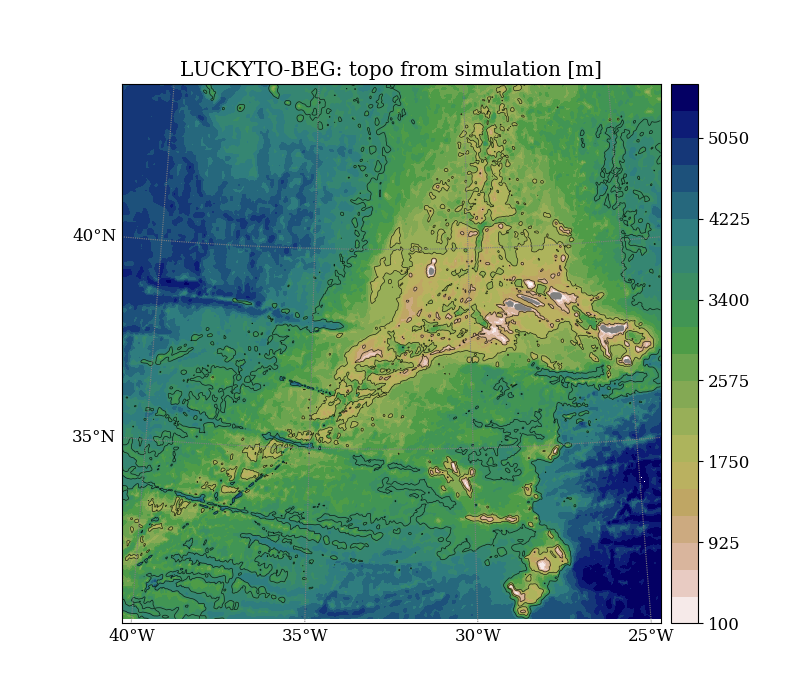

In [4]:
# Load data: grid & topo
doploth = True  # plot topo 

ncg = Dataset(fil_grd,'r')
slix = slice(1,2000,st)
sliy = slice(1,2000,st)
lon = ncg.variables['lon_rho'][sliy,:][:,slix]
lat = ncg.variables['lat_rho'][sliy,:][:,slix]
dx = .5*(np.mean(1./ncg.variables['pm'][:]) + np.mean(1./ncg.variables['pn'][:]) ) * st
Ny, Nx = lon.shape
if xm is not None:
    jm, im = np.unravel_index( ((lon-xm)**2 + (lat-ym)**2).argmin(), (Ny,Nx) )
    j1, j2 = jm + np.array([-1,1])*int(Lx/dx/2.)
    i1, i2 = im + np.array([-1,1])*int(Ly/dx/2.)
    print("jjs, iis:",j1,j2,i1,i2, "from parent: X",st)
else:
    j1, j2, i1, i2 = 0, Ny, 0, Nx
topo = ncg.variables['h'][sliy,:][:,slix][j1:j2,i1:i2]
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]
print("loaded grid")
lonm, latm = lon.mean(axis=0), lat.mean(axis=1)
ny, nx = lon.shape
if rlevs is not None and len(rlevs)>0:
    rad = gsw.distance(np.c_[lon.ravel(),np.ones(nx*ny)*xm],np.c_[lat.ravel(),np.ones(nx*ny)*ym]).reshape(ny,nx)/1e3 # [km]
else:
    rad = None
print("min/max lon, lat:", lon.min(), lon.max(), lat.min(), lat.max())
# plot it
if doploth:
    vmin, vmax = round(topo.min()+50,-2), round(topo.max()-50,-2)
    levs = np.linspace(vmin, vmax, 21)
    fig = plt.figure(figsize=(8,7))
    ax = plt.gca()
    bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),\
            lat_0=lat.mean(),width=Lx,height=Ly)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    hct = bm.contourf(xx, yy, topo, levels=levs, cmap="gist_earth_r")
    hcb = bm.colorbar(hct)
    for item in hct.collections:
        item.set_rasterized(True)
    hct = bm.contour(xx, yy, topo, levels=zlevs, colors=topocol, linewidths=0.5, alpha=0.8)
    for item in hct.collections:
        item.set_rasterized(True)
        
    plt.title(simul.upper()+": topo from simulation [m]")
    
    if dosavefig:
        fig.savefig(dirpic+simul+"_topo.pdf", magnification="auto", bboxçinches="tight", dpi=200)

In [20]:
suf = "_lf"
    
# load data
print("loading", end="... ")
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
var = "ekint"
print(var, end=", ")
ekavg = ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
ekint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]
var = "epint"
print(var, end=", ")
epavg = ncbc.variables[var+"_avg"][j1:j2,...][:,i1:i2,...]
epint = ncbc.variables[var+suf][j1:j2,...][:,i1:i2,...][...,it]

print("bclin fluxes", end=", ")
fxavg = ncbc.variables["puint"+"_avg"][j1:j2,...][:,i1:i2,...]
fyavg = ncbc.variables["pvint"+"_avg"][j1:j2,...][:,i1:i2,...]
fxbc = ncbc.variables["puint"+suf][j1:j2,...][:,i1:i2,...][...,it]
fybc = ncbc.variables["pvint"+suf][j1:j2,...][:,i1:i2,...][...,it]

ncbc.close()

print("Cterm")
ncbt = MFDataset(fil_sflux,aggdim='eta_rho')
ctavg = ncbt.variables["Ct_avg"][j1:j2,...][:,i1:i2,...]
cterm = ncbt.variables["Ct"+suf][j1:j2,...][:,i1:i2,...][...,it]
ncbt.close()

# compute div flux
dfav = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
divf = (np.gradient(fxbc, axis=1)/dx + np.gradient(fybc, axis=0)/dx)*1e3

diav = ctavg - dfav
diss = cterm - divf

loading... ekint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


epint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


bclin fluxes, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


Cterm


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


## Snapshots

<IPython.core.display.Javascript object>


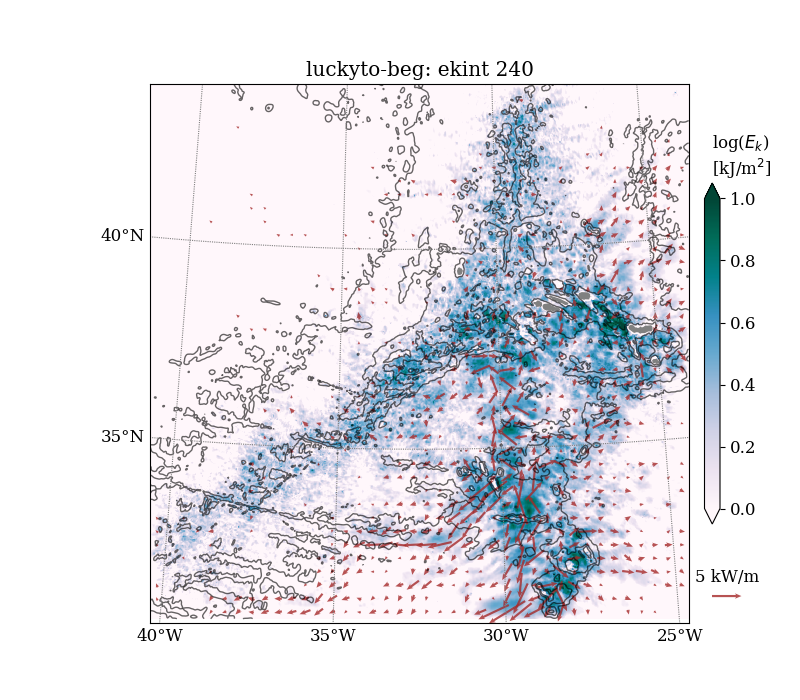

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


In [6]:
# plot data: ekint + flux
mysc = "log" # "log" # "linear"
cmap = "PuBuGn"
topocol = "k"
usq = 5
nsq = 25
color = "brown"
what = "ekint"

toplot = ekint
    
if mysc == "linear":
    vmin, vmax = 0, ekavg.mean() + 5*ekavg.std() 
elif mysc == "log":
    toplot = np.log10(toplot)
    vmax = 1 #np.nanmax(np.log10(davg))
    vmin = 0 #vmax - 1.5
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, vmin=vmin, vmax=vmax, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.formatter.set_powerlimits((-1, 1))
hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="left")

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if dostrflu:
    speed = np.sqrt(fxbc**2 + fybc**2)
    lw = .1 + 4*speed / np.nanmax(speed) # Line Widths
    hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), fxbc, fybc \
                        , density=5, color=color, linewidth=lw)
elif dosqflu:
    slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
    fxpl, fypl = fxbc[sliy,slix], fybc[sliy,slix]
    mask = np.sqrt(fxpl**2 + fypl**2)<.5
    hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                    , np.ma.masked_where(mask, fypl), scale=17, scale_units="inches" \
              , color='brown', pivot="mid", angles="xy", width=4e-3 \
                    , headlength=3, headwidth=2.5, headaxislength=2.5, alpha=.8)
    hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                       , label=r'{} kW/m'.format(usq))
    
plt.title(simul+": {0} {1}".format(what,str(it)))

if dosavefig:
    fig.savefig(dirpic+simul+"_{0}_{1}_{2}.png".format(what,str(it),mysc[:3]), magnification='auto' ,dpi=150, bbox_inches="tight")
    

<IPython.core.display.Javascript object>


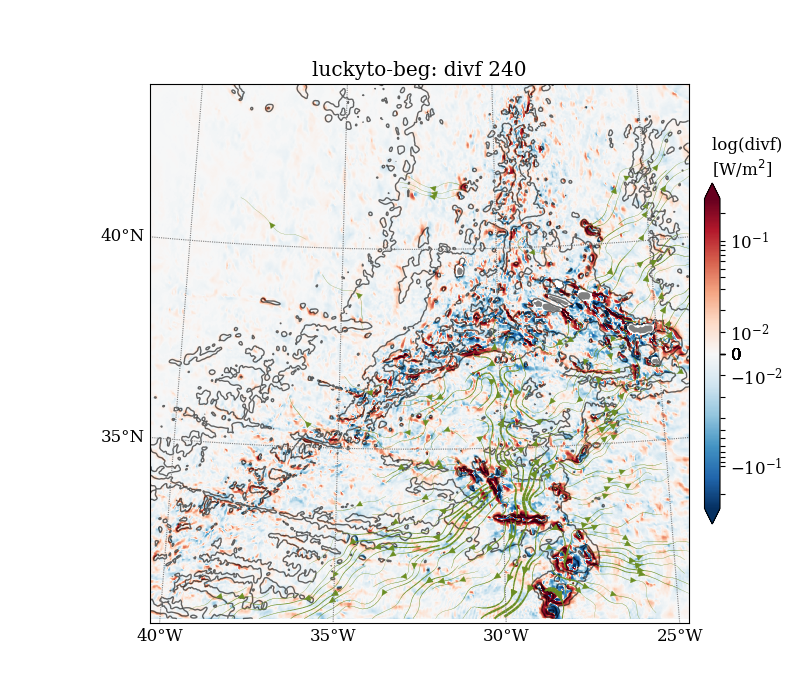

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'luckyto-beg: divf 240')

In [7]:
# plot: conversion term
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "k"
usq = 5
nsq = 25
color = "olivedrab"
what = "divf"
doblur = True

toplot = eval(what)
if doblur:
    toplot = gaussian_filter(toplot, sigma=1, mode="mirror")

if mysc == "lin":
    vmin, vmax = 10*np.nanstd(ctavg) *np.array([-1,1])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
elif mysc == "log":
    vamp = 10*np.nanstd(dfav)
    norm = mpl.colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
    
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),\
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx, yy, toplot, norm=norm, cmap=cmap)
hcb = plt.colorbar(hpc, fraction=.025, extend="both", pad=.025)
hcb.ax.tick_params(labelsize=fs)
if mysc == "log":
    bartit = mysc+"({0})    \n[{1}]    ".format(vnam[what],units[what])
else:
    bartit = "{0}    \n[{1}]    ".format(vnam[what],units[what])
hcb.ax.set_title(bartit, fontsize=fs, ha="left")

#bm.drawmapscale(lonm.mean() - .8*(lonm.max()-lonm.min())/2, latm.mean() + .9*(latm.max()-latm.min())/2, lonm.mean() \
#                ,latm.mean(), length=200, units="km", style="fancy")

if True: # dostrflu:
    speed = np.sqrt(fxbc**2 + fybc**2)
    mask = speed<.5
    lw = 4 * speed / np.nanmax(speed) # Line Widths
    hqv = bm.streamplot(xx.mean(axis=0), yy.mean(axis=1), np.ma.masked_where(mask,fxbc) \
                        , np.ma.masked_where(mask, fybc), density=4, color=color, linewidth=lw)
elif False:#dosqflu:
    slix, sliy = slice(nsq//2,Nx,nsq), slice(nsq//2,Ny,nsq)
    fxpl, fypl = fxbc[sliy,slix], fybc[sliy,slix]
    mask = np.sqrt(fxpl**2 + fypl**2)<.5
    hqb = bm.quiver(xx[sliy,slix], yy[sliy,slix], np.ma.masked_where(mask, fxpl) \
                    , np.ma.masked_where(mask, fypl), scale=17, scale_units="inches" \
              , color='brown', pivot="mid", angles="xy", width=4e-3 \
                    , headlength=3, headwidth=2.5, headaxislength=2.5)
    hqk = ax.quiverkey(hqb, X=1.07, Y=.05, U=usq \
                       , label=r'{} kW/m'.format(usq))
    
plt.title(simul+": {0} {1}".format(what,str(it)))

<IPython.core.display.Javascript object>


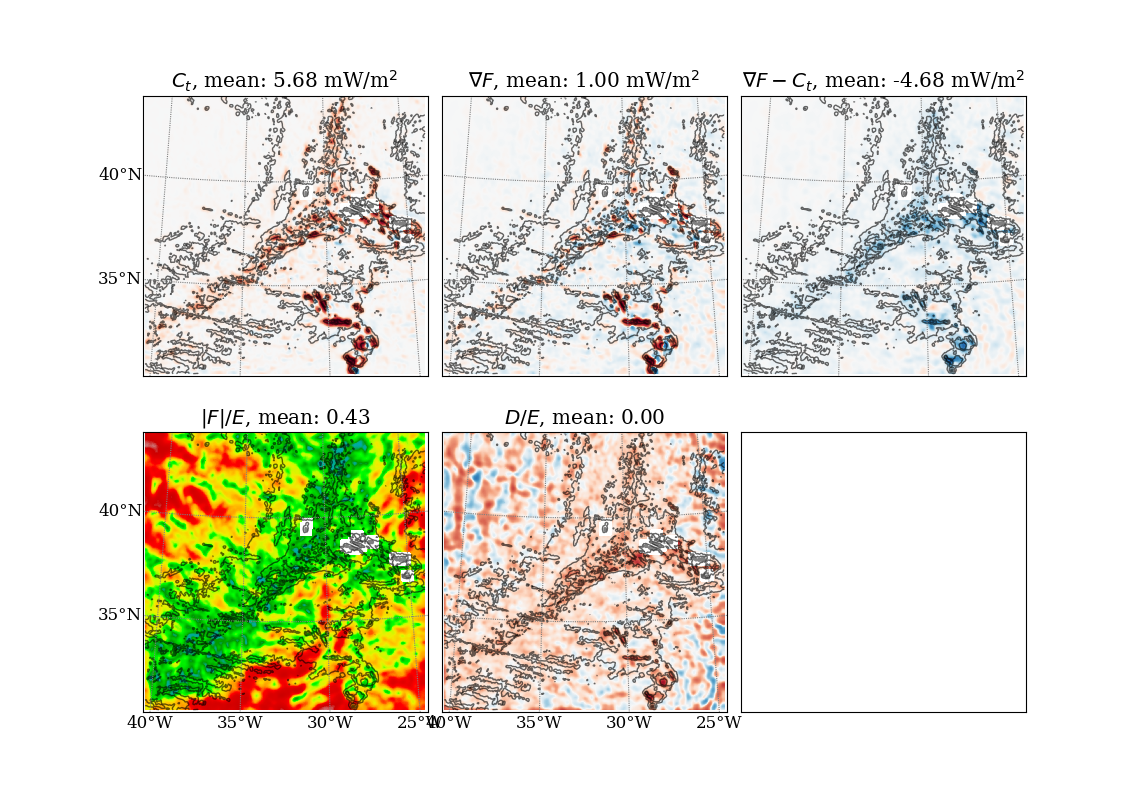

now doing row 1, column 1
cterm -0.289238523692 0.289238523692 <function <lambda> at 0x7f539d6cac80>
now doing row 2, column 1
np.sqrt(fxbc**2+fybc**2)/(ekint+epint) 0.01 2 <function <lambda> at 0x7f539e523510>
now doing row 1, column 2
divf -0.289238523692 0.289238523692 <function <lambda> at 0x7f539d6cac80>
now doing row 2, column 2
diss/(ekint+epint) -0.05 0.05 <function <lambda> at 0x7f539d6cac80>
now doing row 1, column 3
divf-cterm -0.289238523692 0.289238523692 <function <lambda> at 0x7f539d6cac80>


In [105]:
# conversion term, divf and dissipation (difference)
# plot: conversion term
mysc = "log" # "log" # "linear"
cmap = "RdBu_r"
topocol = "k"
usq = 5
nsq = 25
doblur = True

fields = [["cterm", "divf", "divf-cterm"], 
          ['np.sqrt(fxbc**2+fybc**2)/(ekint+epint)', "diss/(ekint+epint)", None]]
tits = [[r"$C_t$", r"$\nabla F$", r"$\nabla F-C_t$"], [r"$|F|/E$", r"$D/E$", None]]
vamps = [[10*np.nanstd(dfav)]*3, [(1e-2,2), .05, None]]
cmaps = [["RdBu_r"]*3, ["nipy_spectral", "RdBu_r", None]]
unit = units[fields[0][0]]
nrow, ncol = 2, 3

vamp = 10*np.nanstd(dfav)
if mysc == "lin":
    nors = lambda vmin,vmax: mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    nora = norms
elif mysc == "log":
    nors = lambda vmin, vmax: mpl.colors.SymLogNorm(linthresh=vmax/10, linscale=1, vmin=vmin, vmax=vmax)
    nora = lambda vmin, vmax: mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
norms = [[nors]*3, [nora, nors, None]]

fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(ncol*Lx/Ly*3.7+.3,nrow*Ly/Lx*4))
for ia,ib in product(range(ncol),range(nrow)):
    if fields[ib][ia] is None: continue
    ax = axs[ib,ia]
    print("now doing row {0}, column {1}".format(ib+1,ia+1), flush=True)
    bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),\
            lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    bm.drawparallels(np.arange(-60,70,stride),labels=[int(ia==0),0,0,0],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,int(ib==nrow-1)],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=1,alpha=0.6)
    for item in hct.collections:
        item.set_rasterized(True)

    what = fields[ib][ia]
    toplot = eval(what)
    moy = np.nanmean(toplot)
    if isinstance(vamps[ib][ia], tuple):
        vmin, vmax = vamps[ib][ia]
    else: 
        vmin, vmax = -vamps[ib][ia], vamps[ib][ia]
    if doblur:
        toplot = gaussian_filter(toplot, sigma=5, mode="mirror")
    print(what, vmin, vmax, norms[ib][ia])
    hpc = bm.pcolormesh(xx, yy, toplot, norm=norms[ib][ia](vmin, vmax), cmap=cmaps[ib][ia])
    if ib==0:
        ax.set_title('{0}, mean: {1:.2f} m{2}'.format(tits[ib][ia], moy*1e3, unit))
    else:
        ax.set_title('{0}, mean: {1:.2f}'.format(tits[ib][ia], moy))

plt.subplots_adjust(wspace=.05)

## Time evolution
of integrated quantities

In [107]:
# load data (Integrated NRJ and flux, and generation/divergence/dissipation)
# WARNING memory consuming !

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
times = ncbc.variables['scrum_time'][:]/24
ekmean = np.nanmean(ncbc.variables['ekint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
epmean = np.nanmean(ncbc.variables['epint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
flmean = np.nanmean(np.sqrt((ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]**2 \
                  + ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]**2)), axis=(0,1))
ncbc.close()

#times = np.arange(Nt)/24.

# conversion, div flux and dissipation
# load div flux
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
fubc = ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]
fvbc = ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]
ncbc.close()
divf = np.nanmean(fubc[:,-1,:] - fubc[:,0,:], axis=0)/Nx/dx + np.nanmean(fvbc[-1,:,:] - fvbc[0,:,:], axis=0)/Ny/dx

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
cterm = np.nanmean(ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ekbt = np.nanmean(np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2), axis=(0,1))
ncbt.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.p

<IPython.core.display.Javascript object>


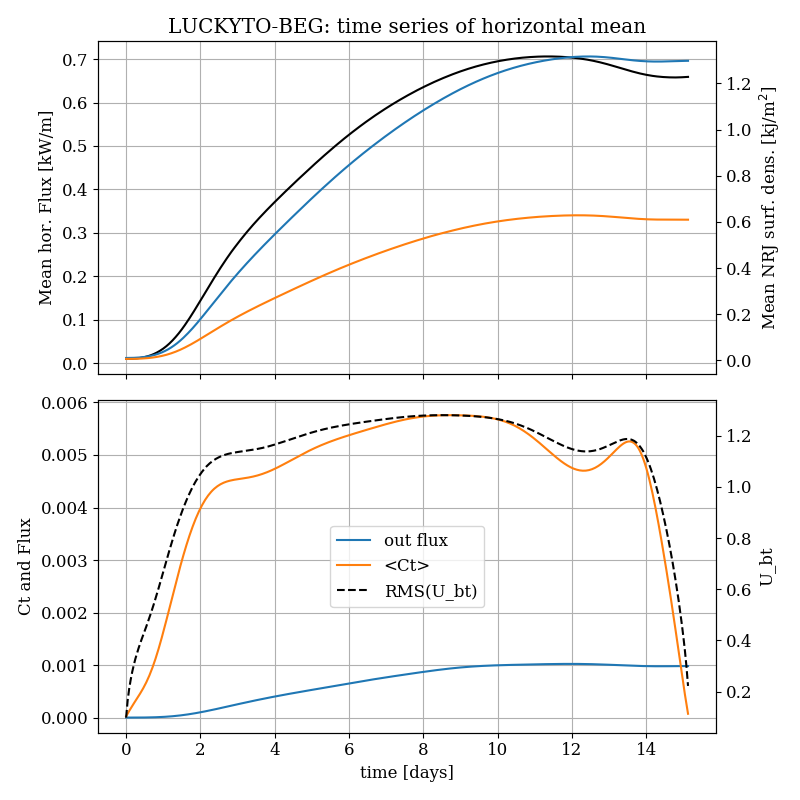

In [108]:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
# NRJ (and flux) horizontal mean
ax = axs[0]
ax.plot(times, flmean, "k", label="Flux")
ax.set_ylabel(r'Mean hor. Flux [kW/m]')

axb = plt.twinx(ax)
axb.plot(times, ekmean, label="KE")
axb.plot(times, epmean, label="PE")
axb.set_ylabel(r'Mean NRJ surf. dens. [kj/m$^2$]')

# conversion, dissipation
ax = axs[1]
ax.plot(times, divf*1e3, label="out flux")
ax.plot(times, cterm, label="<Ct>")
bx = ax.twinx()
bx.plot(times, ekbt, "--k", label="RMS(U_bt)")
ax.grid(True)
ax.set_ylabel("Ct and Flux")
bx.set_ylabel("U_bt")
ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

for ax in axs:
    ax.grid(True)
ax.set_xlabel('time [days]')

axs[0].set_title(simul.upper()+': time series of horizontal mean')
fig.set_tight_layout(True)

if dosavefig:
    fig.savefig(dirpic+simul+"_MeanBclinNRJ_tseries.pdf", magnification="auto", bbox_inches="tight")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


<IPython.core.display.Javascript object>


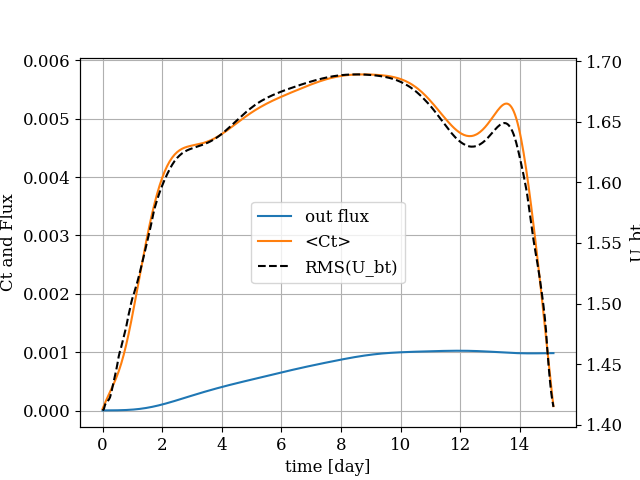

In [12]:
plt.figure()
ax = plt.subplot(111)
ax.plot(times, divf*1e3, label="out flux")
ax.plot(times, cterm, label="<Ct>")
bx = ax.twinx()
bx.plot(times, ekbt, "--k", label="RMS(U_bt)")
ax.grid(True)
ax.set_ylabel("Ct and Flux")
bx.set_ylabel("U_bt")
ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

In [50]:
simul

'luckyto'